# Binary classification of chest x-rays to detect COVID-19
(c) Kevin Gräf, 2021-07-11
# Introduction
This notebook is part of a coding bootcamp project called "chestX" hosted by TechLabs Berlin. ChestX is a webapp that detect COVID-19 from chest x-ray images (CXR) with the help of a computer vision model. For more information please refer to our GitHub: https://github.com/TechLabs-Berlin/st21-chestX

### Interpreting CXRs
- X-ray images are grayscale with values ranging from 0 (black) to 255 (white) 
- The values correlate to the density of the body's area:
    - black: air 
    - dark grey: subcutaneous tissues or fat
    - light grey: soft tissues like the heart and blood vessels 
    - off white: bones such as the ribs
    - bright white: metallic objects such as pacemakers or necklace 
- If something happens in the lungs, such as pneumonia, the air-dense lungs change into water-dense lungs. This causes the demarcation lines to fade since the pixel densities start closing in on the grayscale bar.
- About 20% of patients infected with COVID-19 develop pulmonary infiltrates and some develop very serious abnormalities. 

### Why CXRs?
- Portable chest X-rays are likely to be one of the most common modalities for the identification and follow-up of COVID-19 lung abnormalities.
- CT rooms are more difficult to decontaminate and they are not as available in different parts of the world as x-ray machines
- Deep Learning techniques have proven to be beneficial in both classifying abnormalities from lung x-ray images and aiding the radiologists to accurately predict COVID-19 cases in a reduced time frame.

Source: https://link.springer.com/article/10.1007/s42979-021-00496-w

### The dataset
The dataset used: https://www.kaggle.com/tawsifurrahman/covid19-radiography-database 

Which is a collection from the following resources:
- [1]https://bimcv.cipf.es/bimcv-projects/bimcv-covid19/#1590858128006-9e640421-6711
- [2]https://github.com/ml-workgroup/covid-19-image-repository/tree/master/png
- [3]https://sirm.org/category/senza-categoria/covid-19/
- [4]https://eurorad.org
- [5]https://github.com/ieee8023/covid-chestxray-dataset
- [6]https://figshare.com/articles/COVID-19_Chest_X-Ray_Image_Repository/12580328
- [7]https://github.com/armiro/COVID-CXNet
- [8]https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data
- [9] https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

### Data composition
The dataset contains 3616 COVID-19 positive cases, 10192 Normal, 6012 Lung Opacity (Non-COVID lung infection), and 1345 Viral Pneumonia images. In total, that makes 17549 COVID-19 negative and 3616 positive images and therefore a quite biased dataset (A positive to negative ratio of 20.61%.).

In [1]:
# Install dependencies
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab
from fastai.vision.all import *

# Create a DataLoaders object

A **DataLoader** is an iterator that provides a stream of mini-batches. Each mini-batch is a tuple of an independent variables batch and a dependent variables batch. The **DataLoaders** object contains a training DataLoader and a validation DataLoader.

In [2]:
# Save current working directory as pathlib.Path object
path = Path("../input/covid19-radiography-database/COVID-19_Radiography_Dataset")
path

Path('../input/covid19-radiography-database/COVID-19_Radiography_Dataset')

In [3]:
# List all files in path
path.ls()

(#9) [Path('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx'),Path('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal.metadata.xlsx'),Path('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/README.md.txt'),Path('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID.metadata.xlsx'),Path('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal'),Path('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity'),Path('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx'),Path('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia'),Path('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID')]

In [4]:
# Grab file names recursively
fnames = get_image_files(path)
fnames

(#21165) [Path('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-859.png'),Path('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-158.png'),Path('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-10121.png'),Path('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-1811.png'),Path('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-97.png'),Path('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-1088.png'),Path('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-5663.png'),Path('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-6328.png'),Path('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-8410.png'),Path('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-5641.png')...]

The dataset contains four different folders: COVID, Lung_Opacity, Normal, Viral Pneumonia. But we want to create a **binary** classifier and therefore we will refer to every image that is not in the COVID folder as a 0 and every image in the COVID folder as a 1. 

In [5]:
# Function for binary labelling
def label_func(fname):
    if parent_label(fname)=="Lung_Opacity":
        return 0
    if parent_label(fname)=="Normal":
        return 0
    if parent_label(fname)=="Viral Pneumonia":
        return 0
    else:
        return 1

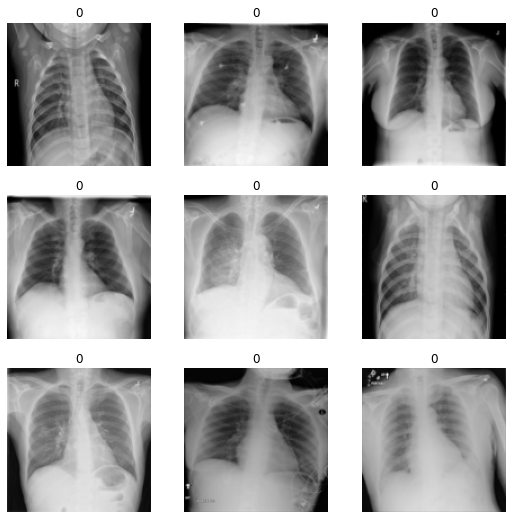

In [6]:
# Construct the DataLoaders object
dbl = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                get_y     = label_func,
                splitter  = RandomSplitter(valid_pct=0.2, seed=42),
                item_tfms = Resize(128))

dls = dbl.dataloaders(fnames)
dls.show_batch()

In [7]:
# Show size of training and validation set 
len(dls.train_ds), len(dls.valid_ds)

(16932, 4233)

# Train a model
The `cnn_learner` function is used to initiate the training.

In [8]:
# To make the metric calculation reproducible a seed is set
import random
set_seed(123)

learn = cnn_learner(dls, resnet18, metrics=[error_rate,accuracy])
learn.fine_tune(6)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.385389,0.228667,0.087172,0.912828,02:17


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.116783,0.068792,0.023388,0.976612,01:38
1,0.062378,0.042612,0.011812,0.988188,01:38
2,0.038904,0.035482,0.009922,0.990078,01:40
3,0.012200,0.028145,0.008505,0.991495,01:39
4,0.005713,0.024176,0.007560,0.992440,01:38
5,0.001042,0.023976,0.006615,0.993385,01:39


We didn't specify a loss function, therefore fastai will try to choose the best selection for the task. Let's check which one it was.

In [9]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

We can do the same for the optimization function.

In [10]:
learn.opt_func

<function fastai.optimizer.Adam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)>

# Result evaluation of the model
The resnet18 model trained for 6 epochs only, already achieves more than 99% accuracy. However, accuracy is not the only measure that should be considered for model evaluation. Other metrics that will be analysed here are:

## False Positive & False Negative
- **False Positive** the test is positive but the patient actually is COVID-negative.
- **False Negative** the test is negative but the patient actually is COVID-positive

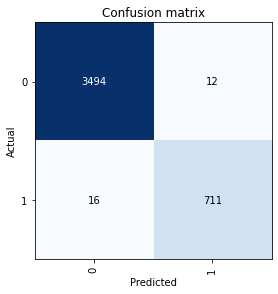

In [11]:
# Interprete the model
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [12]:
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)

True

In [13]:
# Assign variables to each quadrant of the confusion matrix
upp, low = interp.confusion_matrix()
tn, fp = upp[0], upp[1]
fn, tp = low[0], low[1]
print(tn, fp, fn, tp)

3494 12 16 711


## Sensitivity & Specificity
- **Sensitivity** or **True Positive Rate**: The test is positive given that the patient actually is positive. Sensitivity measures the avoidance of false negatives.
- **Specificity** or **True Negative Rate**: The test is negative given that the patient actually is negative. Specificity measure the avoidance of false positives.
- Example: A new test for COVID-19 was tested on 20,000 patients, 10,000 of which are known to have the disease. 
    - If this test correctly classified 9000 patients as positive (true positive) but classifies 1000 as negative (false negative), the test would have a sensitivity of 90% (true positive rate).
    - $Sensitivity = TP/(TP+FN) = 9000/(9000+1000) = 9000/10,000 = 0.90$
    - If this test correctly classified 8000 patients as negative (true negative) but classifies 2000 as positive (false positive), the test would have a specificity of 80% (true negative rate).
    - $Specificity = TN/(TN+FP) = 8000/(8000+2000) = 8000/10,000 = 0.80$
    
Which metric is more meaningful when trying to detect a disease?
A COVID-test should foremost have a high sensitivity. In other words, the test should detect as much positive patients as possible. On the other hand, a diagnostic tool with a low specificity will be useless as it will falsely classify too many patients as positive even though they are not. 

In [14]:
sensitivity = tp/(tp + fn)
sensitivity

0.9779917469050894

The model has a sensitivity (true positive rate) of ~97.25. This means that it is capable of correctly detecting 97.25% true positives (patient has COVID and is detected) and will miss 2.75% of false negatives (patient has COVID but is *not* detected). Also known as **Type II error**.

In [15]:
specificity = tn/(tn + fp)
specificity

0.9965772960638904

The model has a specificity (true negative rate) of ~99.66% which means almost all COVID-negative patients will be be correctly classified as negative. Also known as **Type I error**.

## Positive Predictive Value (Precision) & Negative Predictive Value (Recall)
Diagnostic tests are often evaluated via PPV (Positive Predictive Value) or NPV (Negative Predictive Value).
- **PPV**: If the model predicts a patient has a condition what is the probability that the patient actually has the condition
- **NPV**: If the model predicts a patient does not have a condition what is the probability that the patient actually does not have the condition

The ideal value of the PPV, with a perfect test, is 1 (100%), and the worst possible value would be zero.

The ideal value of the NPV, with a perfect test, is 1 (100%), and the worst possible value would be zero.

In [16]:
ppv = tp/(tp+fp)
ppv

0.983402489626556

In [17]:
npv = tn/(tn+fn)
npv

0.9954415954415955

The PPV is slightly lower than the NPV which means that it is better at detecting COVID-positive patients than COVID-negative. This could be because the training dataset contains fewer positive than negative images. However, the metrics should be considered very good. 

# Interpretation of the model
- Show images where the model failed.
- what does the average “positive example” look like vs the average “negative example”
- Is it possible to discern these differences visually? mathematically?

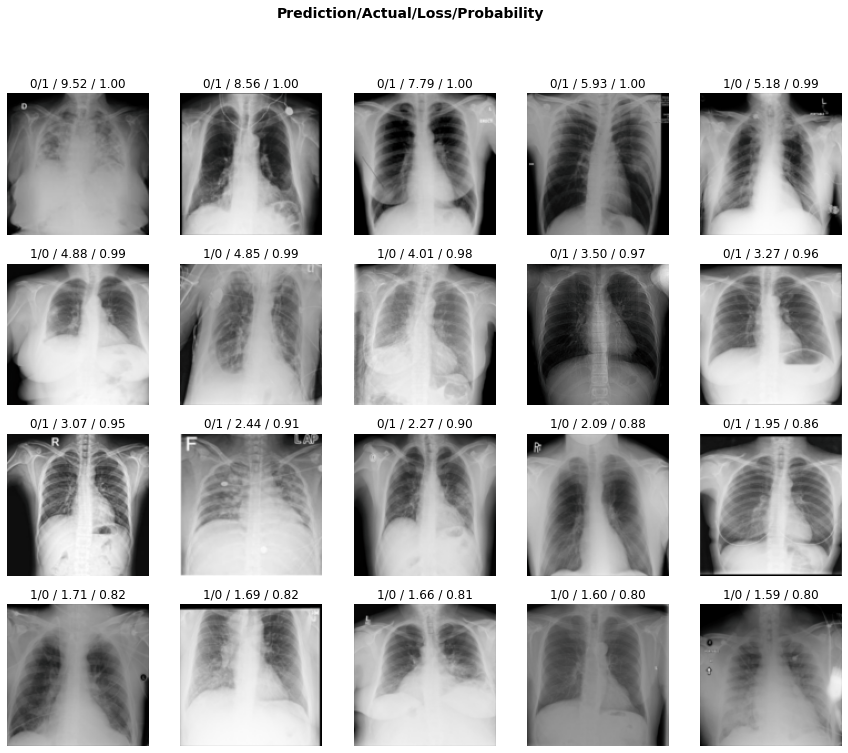

In [55]:
# Plot images with the highest loss 
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(20)

In [86]:
# Print filenames of top losses
losses, idxs = interp.top_losses(20)
l = 0
for i in idxs:
    print(f"Loss: {round(float(losses[l]),2)}\tFilename: {dls.valid_ds.items[i]}")
    l += 1

Loss: 9.52	Filename: ../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/COVID-895.png
Loss: 8.56	Filename: ../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/COVID-1275.png
Loss: 7.79	Filename: ../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/COVID-588.png
Loss: 5.93	Filename: ../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/COVID-1604.png
Loss: 5.18	Filename: ../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-8928.png
Loss: 4.88	Filename: ../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/Lung_Opacity-4540.png
Loss: 4.85	Filename: ../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/Lung_Opacity-4927.png
Loss: 4.01	Filename: ../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/Lung_Opacity-1319.png
Loss: 3.5	Filename: ../input/covid19-radiography-database/COVID-19_Radiography_Dataset

It seems like most of the images with a high loss are COVID-possitive or Lung_Opacity. Reasons for that could be that Lung_Opacity images look a lot like COVID-positive images.

# Test the model
To perform some manual sanity checks, the model will be tested on some (hopefully) unseen CXRs. Futhermore, it will be tested on unrelated images that are not CXRs.

In [ ]:
# Load exported model for deployment 
learn_inf = load_learner("../input/covidmodel/binary_model.pkl") 

In [ ]:
# Predict COVID on "test" images
#pos
print(learn_inf.predict('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/COVID-1011.png'))
#pos
#print(learn_inf.predict('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/COVID-1012.png'))
#neg
#print(learn_inf.predict('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-10.png'))
#neg
#print(learn_inf.predict('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/Lung_Opacity-1004.png'))
#neg
#print(learn_inf.predict('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/Viral Pneumonia-1000.png'))